# Creating Labeled Data from a Planet Mosaic with Label Maker

In this notebook, we create labeled data for training a machine learning algorithm. As inputs, we use [OpenStreetMap](https://www.openstreetmap.org/#map=4/38.01/-95.84) as the ground truth source and a Planet mosaic as the image source. Developmentseed's [Label Maker](https://developmentseed.org/blog/2018/01/11/label-maker/) tool is used to download and prepare the ground truth data and chip the Planet imagery. 

In [1]:
import json
import os

from IPython.display import Image
import numpy as np

## Define Mosaic Parameters

In [2]:
# Planet tile server base URL (Planet Explorer Mosaics Tiles)
series = 'global_monthly_2018_02_mosaic'
mosaicsTilesURL_base = 'https://tiles.planet.com/basemaps/v1/planet-tiles/{}/gmap/{{z}}/{{x}}/{{y}}.png'.format(series)
mosaicsTilesURL_base

'https://tiles.planet.com/basemaps/v1/planet-tiles/global_monthly_2018_02_mosaic/gmap/{z}/{x}/{y}.png'

In [3]:
# Planet tile server url with auth
planet_api_key = os.environ['PL_API_KEY']
planet_mosaic = mosaicsTilesURL_base + '?api_key=' + planet_api_key

## Prepare label maker config file

This config file is pulled from the label-maker repo [README.md](https://github.com/developmentseed/label-maker/blob/master/README.md) example and then customized to utilize the planet mosaic. The imagery url is pointed to the planet mosaic url with the planet api key and the zoom is changed to 15, the maximum zoom supported by the [planet tileservices](https://developers.planet.com/docs/api/tile-services/).

See the label-maker README.md file for a description of the config entries.

In [4]:
# create data directory
data_dir = os.path.join('data', 'label-maker-mosaic')
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

In [5]:
# start with a clean slate
!cd $data_dir && rm -R *

rm: cannot remove '*': No such file or directory


In [6]:
# create config file
config = {
  "country": "togo",
  "bounding_box": [1.09725, 6.05520, 1.34582, 6.30915],
  "zoom": 15,
  "classes": [
    { "name": "Roads", "filter": ["has", "highway"] },
    { "name": "Buildings", "filter": ["has", "building"] }
  ],
  "imagery": planet_mosaic,
  "background_ratio": 1,
  "ml_type": "classification"
}

# define project files and folders
config_filename = os.path.join(data_dir, 'config.json')

# write config file
with open(config_filename, 'w') as cfile:
    cfile.write(json.dumps(config))

print('wrote config to {}'.format(config_filename))

wrote config to data/label-maker-mosaic/config.json


## Download OSM tiles

In this step, label-maker downloads the OSM vector tiles for the country specified in the config file.

In [7]:
!cd $data_dir && label-maker download

Saving QA tiles to data/togo.mbtiles
   100%     26.6 MiB       4.1 MiB/s            0:00:00 ETA    


## Create ground-truth labels from OSM tiles

In this step, the OSM tiles are chipped into label tiles at the zoom level specified in the config file.

In [8]:
!cd $data_dir && label-maker labels

Retiling QA Tiles to zoom level 15 (takes a bit)
173820 features, 10707986 bytes of geometry, 4700 bytes of separate metadata, 2544939 bytes of string pool
  99.9%  15/16500/15820  
Determining labels for each tile
---
Roads: 370 tiles
Buildings: 270 tiles
Total tiles: 576
Writing out labels to data/labels.npz


## Preview image chips

Create a subset of the image chips for preview before creating them all.

In [9]:
!cd $data_dir && label-maker preview -n 3

Writing example images to data/examples


In [10]:
!ls $data_dir/data/examples

Buildings  Roads


data/label-maker-mosaic/data/examples/Roads
16483-15809-15.png


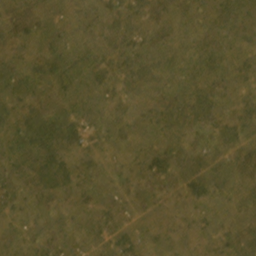

16483-15810-15.png


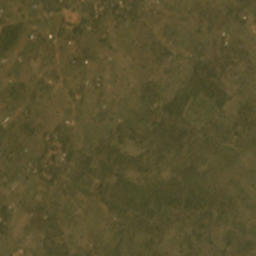

16483-15811-15.png


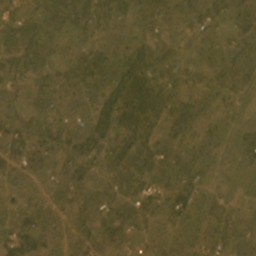

16483-15812-15.png


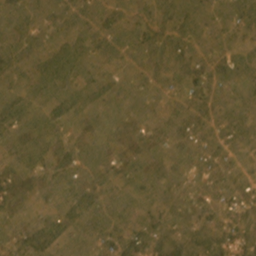

data/label-maker-mosaic/data/examples/Buildings
16483-15815-15.png


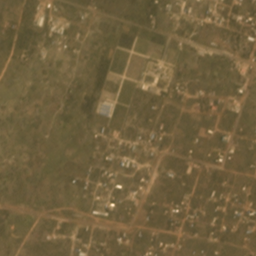

16483-15816-15.png


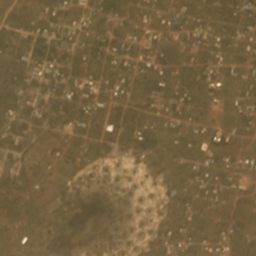

16483-15817-15.png


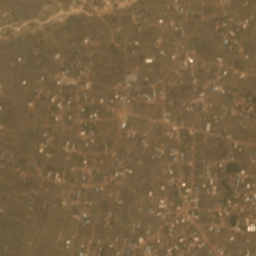

16483-15818-15.png


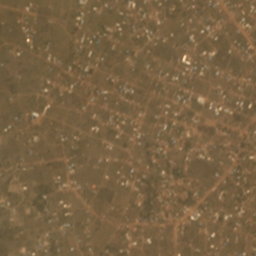

In [11]:
for fclass in ('Roads', 'Buildings'):
    example_dir = os.path.join(data_dir, 'data', 'examples', fclass)
    print(example_dir)
    for img in os.listdir(example_dir):
        print(img)
        display(Image(os.path.join(example_dir, img)))

Other than the fact that 4 tiles were created instead of the specified 3, the results look pretty good! All Road examples have roads, and all Building example have buildings.

## Create image tiles

We invoke `label-maker images`, which downloads and chips the mosaic into tiles that match the label tiles.

In [12]:
!cd $data_dir && label-maker images

data/label-maker-mosaic/data/tiles
16483-15809-15.png


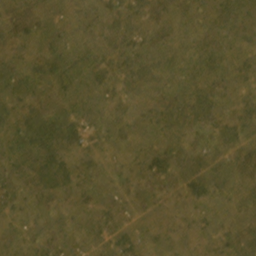

16483-15810-15.png


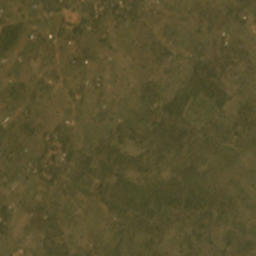

16483-15811-15.png


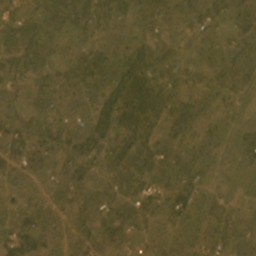

In [13]:
# look at three tiles that were generated
tiles_dir = os.path.join(data_dir, 'data', 'tiles')
print(tiles_dir)
for img in os.listdir(tiles_dir)[:3]:
    print(img)
    display(Image(os.path.join(tiles_dir, img)))

## Package tiles and labels

Convert the image and label tiles into train and test datasets.

In [14]:
# will not be able to open tiles that weren't generated, aka those that didn't contain 
# vector features matching specified classes
!cd $data_dir && label-maker package

Couldn't open data/tiles/16497-15814-15.png, skipping
Couldn't open data/tiles/16490-15831-15.png, skipping
Couldn't open data/tiles/16489-15829-15.png, skipping
Couldn't open data/tiles/16495-15829-15.png, skipping
Couldn't open data/tiles/16501-15819-15.png, skipping
Couldn't open data/tiles/16498-15830-15.png, skipping
Couldn't open data/tiles/16492-15827-15.png, skipping
Couldn't open data/tiles/16492-15829-15.png, skipping
Couldn't open data/tiles/16503-15824-15.png, skipping
Couldn't open data/tiles/16491-15828-15.png, skipping
Couldn't open data/tiles/16484-15828-15.png, skipping
Couldn't open data/tiles/16487-15830-15.png, skipping
Couldn't open data/tiles/16496-15828-15.png, skipping
Couldn't open data/tiles/16505-15817-15.png, skipping
Couldn't open data/tiles/16489-15830-15.png, skipping
Couldn't open data/tiles/16499-15825-15.png, skipping
Couldn't open data/tiles/16492-15831-15.png, skipping
Couldn't open data/tiles/16506-15823-15.png, skipping
Couldn't open data/tiles/165

Couldn't open data/tiles/16505-15828-15.png, skipping
Couldn't open data/tiles/16502-15816-15.png, skipping
Couldn't open data/tiles/16483-15808-15.png, skipping
Couldn't open data/tiles/16494-15830-15.png, skipping
Couldn't open data/tiles/16500-15815-15.png, skipping
Couldn't open data/tiles/16502-15817-15.png, skipping
Couldn't open data/tiles/16505-15823-15.png, skipping
Couldn't open data/tiles/16483-15823-15.png, skipping
Couldn't open data/tiles/16505-15826-15.png, skipping
Couldn't open data/tiles/16485-15828-15.png, skipping
Couldn't open data/tiles/16488-15829-15.png, skipping
Couldn't open data/tiles/16483-15829-15.png, skipping
Couldn't open data/tiles/16493-15828-15.png, skipping
Couldn't open data/tiles/16497-15830-15.png, skipping
Couldn't open data/tiles/16488-15830-15.png, skipping
Couldn't open data/tiles/16504-15830-15.png, skipping
Couldn't open data/tiles/16493-15830-15.png, skipping
Couldn't open data/tiles/16504-15825-15.png, skipping
Couldn't open data/tiles/165

## Check Package

Let's load the packaged data and look at the train and test datasets.

In [15]:
data_file = os.path.join(data_dir, 'data', 'data.npz')
data = np.load(data_file)

In [16]:
for k in data.keys():
    print('data[\'{}\'] shape: {}'.format(k, data[k].shape))

data['x_train'] shape: (297, 256, 256, 3)
data['y_train'] shape: (297, 3)
data['x_test'] shape: (75, 256, 256, 3)
data['y_test'] shape: (75, 3)
